<a href="https://colab.research.google.com/github/thomson887/thomson887/blob/main/136948_Python_Forecast_NC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the required packages


In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Turn off an annoying pandas warning
import numpy as np
from matplotlib import pyplot as py
from fbprophet import Prophet
import time

from fbprophet.plot import plot_plotly
import plotly.offline as py
print("packages imported successfully")

# Create a custom function for calculating RMSE
def rmse(predictions, targets):
    return round(np.sqrt(((predictions - targets) ** 2).mean()), 2)

# Set the run mode: 'dev' = fast runtime, no hyperparameter tuning, 'prod' = slow runtime, grid search executed
run_mode = 'dev'

packages imported successfully


Mounting google drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Creating training dataset

In [ ]:
#df= pd.read_csv('/content/drive/MyDrive/Top500/136948_prophet.csv')
df= pd.read_csv('136948_prophet.csv')

In [ ]:
df = df.drop(columns=['sku'])
df = df.drop(columns=['velocity_code'])
df = df.drop(columns=['price_point'])
df = df.drop(columns=['weeks_of_sales_clusterID'])
df = df.drop(columns=['coeff_variance_clusterID'])
df = df.drop(columns=['time_btw_demand_clusterID'])
df = df.drop(columns=['type'])

In [ ]:
df.shape

(1035, 5)

In [ ]:
df.tail()

,business_date,Inv_flag_wh,No_of_days_first_Ecomm_sale_Date,ASP,Qty_Sold
1030,10/27/2021,Y,1130,69.263520,448
1031,10/28/2021,Y,1131,69.002117,417
1032,10/29/2021,Y,1132,68.646497,499
1033,10/30/2021,Y,1133,68.753910,521
1034,10/31/2021,Y,1134,69.126952,291


In [ ]:
df_order = df.filter(['business_date', 'Qty_Sold'] , axis=1)


In [ ]:
df_order

,business_date,Qty_Sold
0,1/1/2019,420
1,1/2/2019,457
2,1/3/2019,457
3,1/4/2019,555
4,1/5/2019,612
...,...,...
1030,10/27/2021,448
1031,10/28/2021,417
1032,10/29/2021,499
1033,10/30/2021,521


Checking for correlation between the variables

<AxesSubplot:>

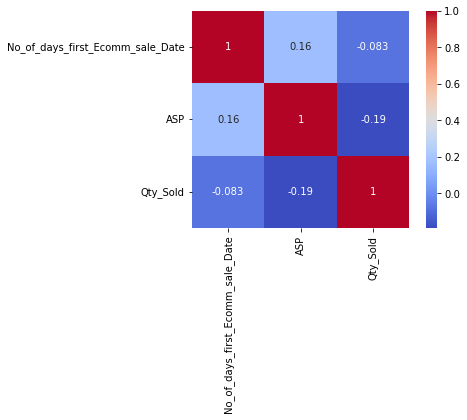

In [ ]:
import seaborn as sns
sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm', square = True)

In [ ]:
df = df.rename(columns={"business_date": "ds", "Qty_Sold": "y"})

In [ ]:
#changing datatype of ds column to datetime64
df.ds = df.ds.astype('datetime64')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ds                                1035 non-null   datetime64[ns]
 1   Inv_flag_wh                       1035 non-null   object        
 2   No_of_days_first_Ecomm_sale_Date  1035 non-null   int64         
 3   ASP                               997 non-null    float64       
 4   y                                 1035 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 40.6+ KB


In [ ]:
#Converting Y/N values in column Inv_flag_wh to 1/0 value
df.Inv_flag_wh = df.Inv_flag_wh.eq('Y').mul(1)

In [ ]:
# Not using type as a regressor anymore.
#Converting 1P/3P values in column "type" to 1/0 value
#df.type = df.type.eq('1P').mul(1)

In [ ]:
#There are null values in ASP. Will have to impute the null values with the previous days values.
df.query('ASP != ASP')

,ds,Inv_flag_wh,No_of_days_first_Ecomm_sale_Date,ASP,y
358,2019-12-25,1,458,NaN,0
551,2020-07-05,1,651,NaN,0
552,2020-07-06,1,652,NaN,0
558,2020-07-12,1,658,NaN,0
871,2021-05-21,1,971,NaN,0
875,2021-05-25,1,975,NaN,0
877,2021-05-27,1,977,NaN,0
882,2021-06-01,0,982,NaN,0
883,2021-06-02,1,983,NaN,0
886,2021-06-05,1,986,NaN,0


In [ ]:
# Imputing null values in column ASP with forward fill function.
df['ASP'] = df['ASP'].fillna(method = 'ffill')

In [ ]:
#checking the value of the imputed ASP.
print(df.ASP.loc[[914]])

914    70.76
Name: ASP, dtype: float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ds                                1035 non-null   datetime64[ns]
 1   Inv_flag_wh                       1035 non-null   int64         
 2   No_of_days_first_Ecomm_sale_Date  1035 non-null   int64         
 3   ASP                               1035 non-null   float64       
 4   y                                 1035 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 40.6 KB


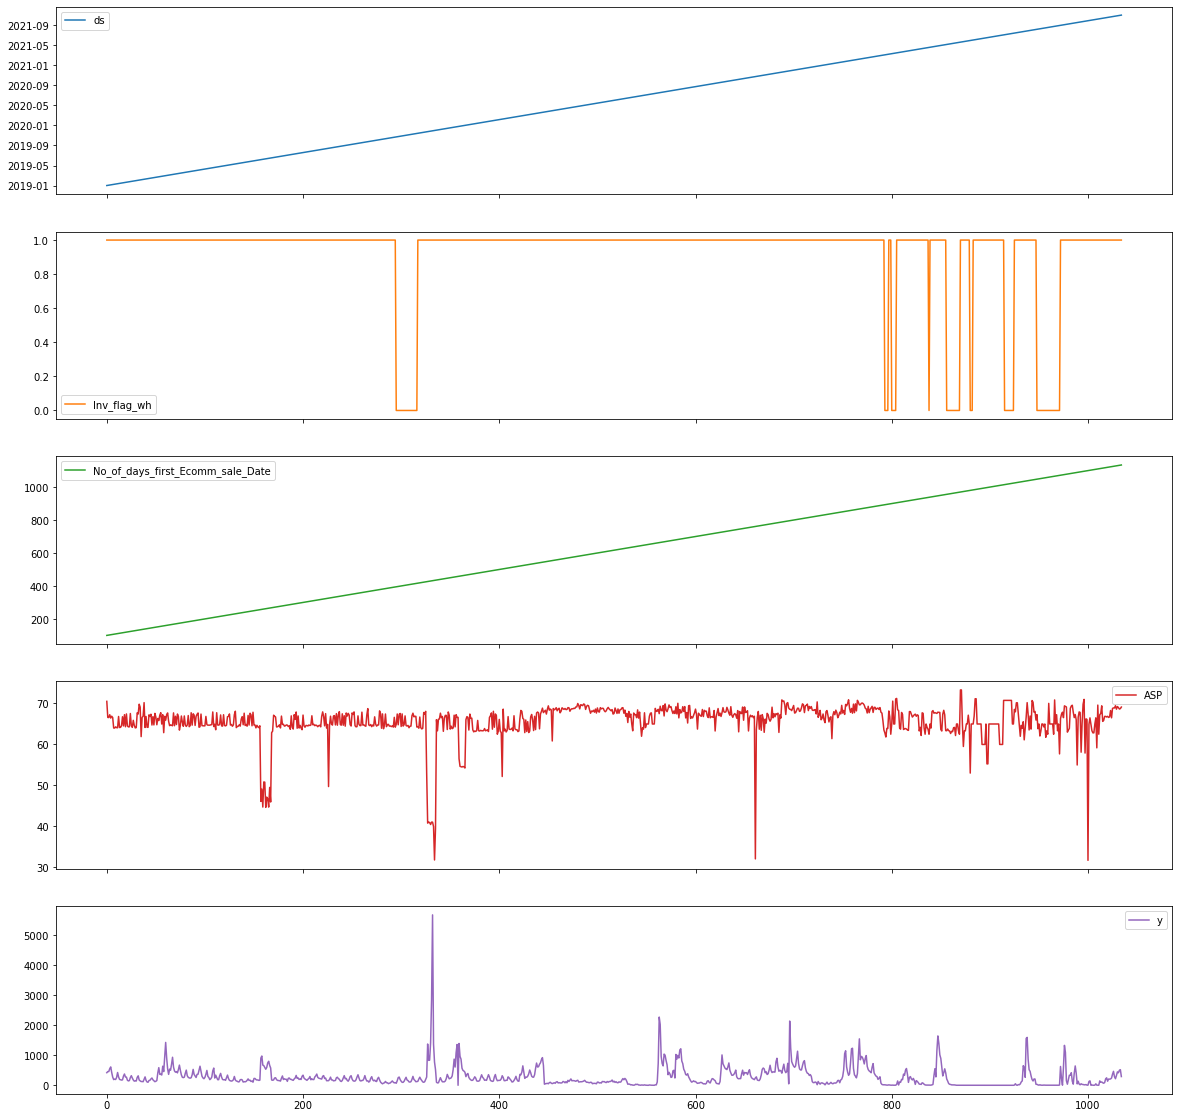

In [ ]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"]=(20,20)
df.plot(subplots=True)
plt.show()



<AxesSubplot:xlabel='ds'>

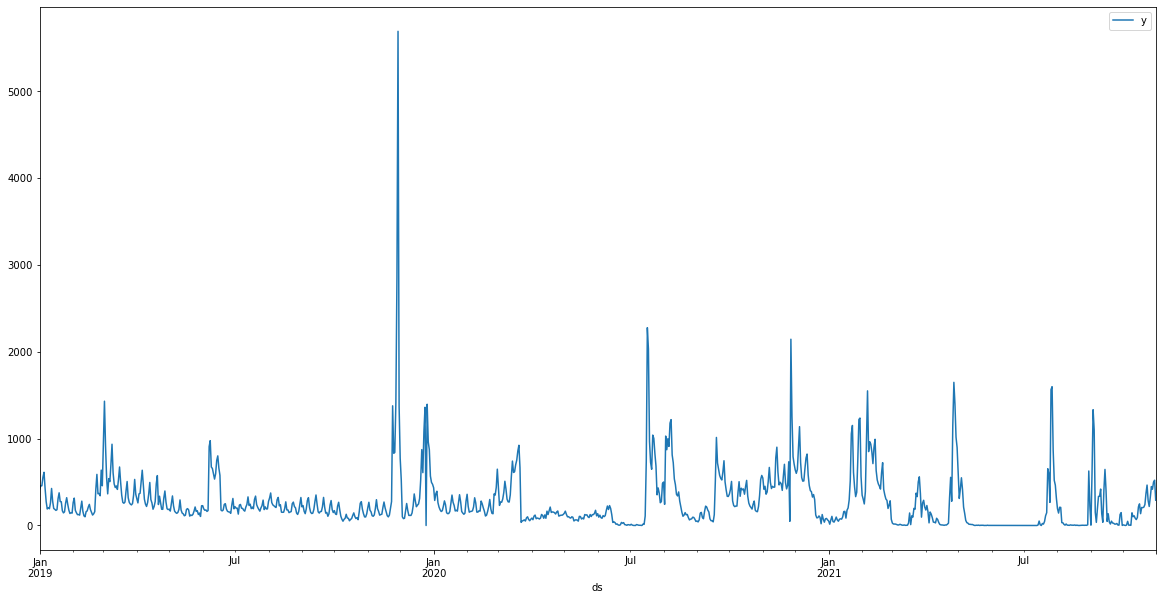

In [ ]:
#Plotting sales of the SKU
#figure(figsize = (10, 6), dpi = 80)
plt.rcParams["figure.figsize"]=(20,10)
df.plot(x='ds', y='y')



(array([17897, 18262, 18628, 18931]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

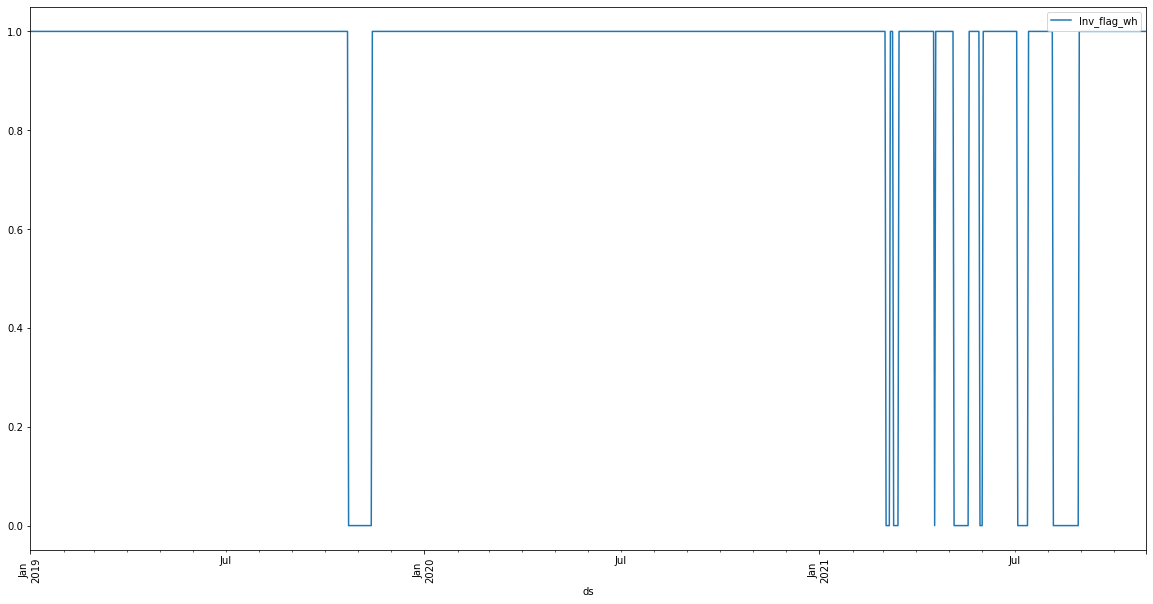

In [ ]:
#Plotting sales of the SKU
#figure(figsize = (10, 6), dpi = 80)
plt.rcParams["figure.figsize"]=(20,10)
df.plot(x='ds', y='Inv_flag_wh')
plt.xticks(rotation=90)


In [ ]:
#Plotting sales of the SKU
#figure(figsize = (10, 6), dpi = 80)
#plt.rcParams["figure.figsize"]=(20,10)
#df.plot(x='ds', y='Inv_flag_wh')


In [ ]:
# Differencing to remove seasonality trends
# df.y = df.y.diff().diff().dropna()

<AxesSubplot:xlabel='ds'>

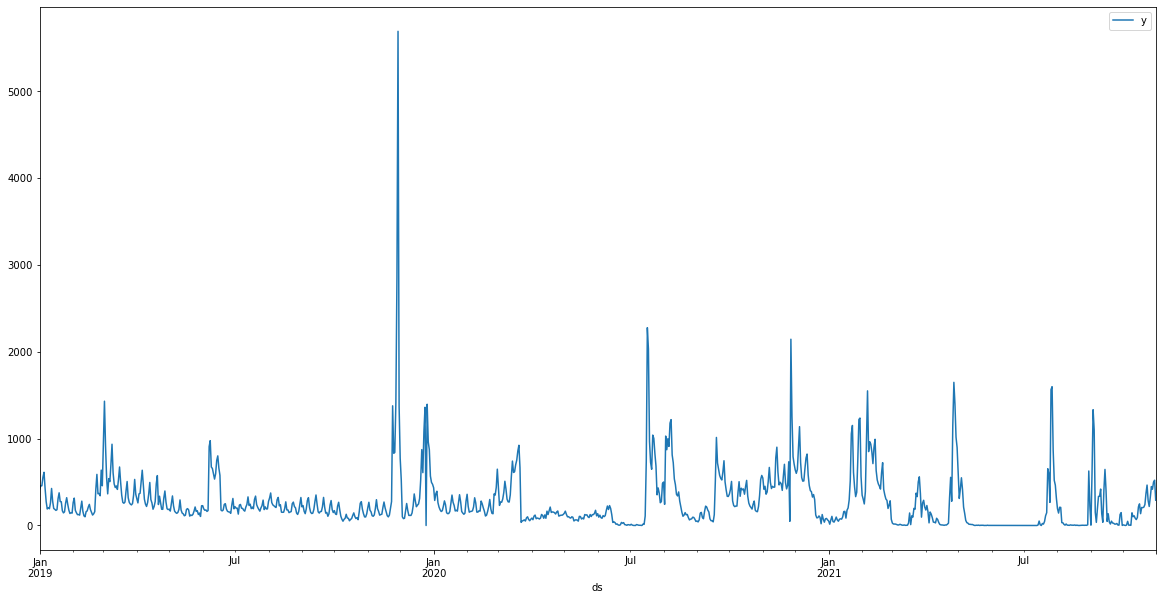

In [ ]:
#Plotting sales of the SKU
#figure(figsize = (10, 6), dpi = 80)
plt.rcParams["figure.figsize"]=(20,10)
df.plot(x='ds', y='y')


In [ ]:
#df_train = df[(df['ds'] <= '2021-06-30')]
#df_test = df[(df['ds'] >= '2021-07-01')]

# Looks like March 21, 2020 is the last date with "normal" sales data, so I'm going to use everything 
# up to this date as the training data, and everything after it as the test data.
df_train = df[(df['ds'] <= '2020-03-21')]
df_test = df[(df['ds'] > '2020-03-21')]

In [ ]:
print(df_train.shape)
print(df_test.shape)

(446, 5)
(589, 5)


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 0 to 445
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ds                                446 non-null    datetime64[ns]
 1   Inv_flag_wh                       446 non-null    int64         
 2   No_of_days_first_Ecomm_sale_Date  446 non-null    int64         
 3   ASP                               446 non-null    float64       
 4   y                                 446 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 20.9 KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589 entries, 446 to 1034
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ds                                589 non-null    datetime64[ns]
 1   Inv_flag_wh                       589 non-null    int64         
 2   No_of_days_first_Ecomm_sale_Date  589 non-null    int64         
 3   ASP                               589 non-null    float64       
 4   y                                 589 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 27.6 KB


Creating Holidays data

In [ ]:
BF = pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2019-11-29','2020-11-27','2021-11-27','2022-11-27']),
  'lower_window': 0,
  'upper_window': 1,
})

CM = pd.DataFrame({
  'holiday': 'Cyber Monday',
  'ds': pd.to_datetime(['2019-12-02','2020-11-30','2021-11-30','2022-11-30']),
  'lower_window': 0,
  'upper_window': 1
})
Thanksgiving = pd.DataFrame({
  'holiday': 'Thanksgiving',
  'ds': pd.to_datetime(['2019-11-28','2020-11-26','2021-11-26','2022-11-26']),
  'lower_window': 0,
  'upper_window': 0,
})
Comiccon = pd.DataFrame({
  'holiday': 'Comicon',
  'ds': pd.to_datetime(['2019-07-18','2021-07-23','2022-07-21']),
  'lower_window': 0,
  'upper_window': 3,
})
superbowl = pd.DataFrame({
  'holiday': 'Superbowl',
  'ds': pd.to_datetime(['2019-02-03','2020-02-02','2021-02-07','2022-02-13']),
  'lower_window': -1,
  'upper_window': 1,
})
xmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2019-12-25','2020-12-25','2021-12-25','2022-12-25']),
  'lower_window': -1,
  'upper_window': 0,
})
easter = pd.DataFrame({
  'holiday': 'Easter',
  'ds': pd.to_datetime(['2019-04-21','2020-04-12','2021-04-04','2022-04-17']),
  'lower_window': -1,
  'upper_window': 0,
})
Independence = pd.DataFrame({
  'holiday': 'Independence Day',
  'ds': pd.to_datetime(['2019-07-04','2020-07-04','2021-07-04','2022-07-04']),
  'lower_window': 0,
  'upper_window': 0, 
})

In [ ]:
holidays = pd.concat((BF,CM,Thanksgiving,xmas,Independence))
holidays

,holiday,ds,lower_window,upper_window
0,Black Friday,2019-11-29,0,1
1,Black Friday,2020-11-27,0,1
2,Black Friday,2021-11-27,0,1
3,Black Friday,2022-11-27,0,1
0,Cyber Monday,2019-12-02,0,1
1,Cyber Monday,2020-11-30,0,1
2,Cyber Monday,2021-11-30,0,1
3,Cyber Monday,2022-11-30,0,1
0,Thanksgiving,2019-11-28,0,0
1,Thanksgiving,2020-11-26,0,0


## Baseline Model

In [ ]:
#initializing the prophet model and tuning the hyper parameters.
m = Prophet()

In [ ]:
#fitting the prophet model on the training dataset
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.28723


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1023.08   0.000761432       98.9036           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       1023.24   0.000496879       68.1742   7.761e-06       0.001      209  LS failed, Hessian reset 
     199       1023.31   2.65033e-05       64.1092      0.6597      0.6597      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       1023.34   5.06224e-08       68.3786      0.2842           1      435   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds'>

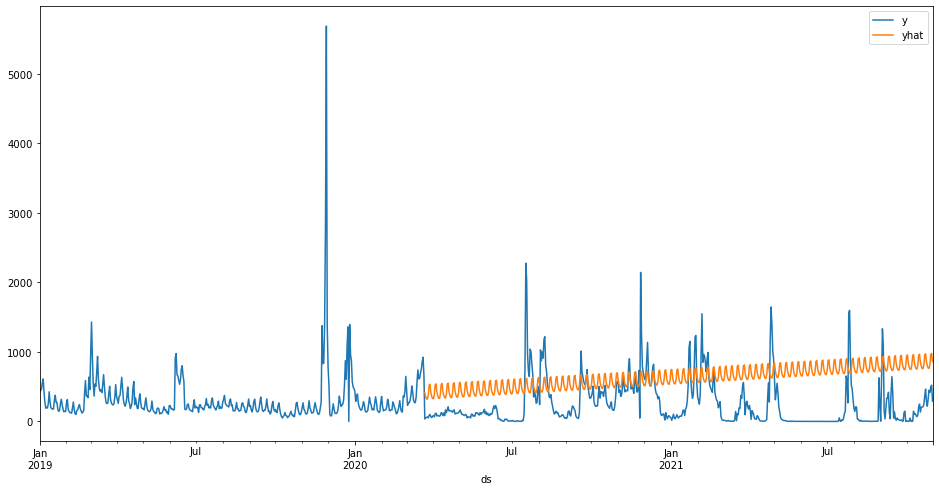

In [ ]:
# Predict on the test data set to see the baseline model performance
future = df_test.drop(columns=['y'])
forecast = m.predict(future)
forecast['yhat'][forecast['yhat'] < 0] = 0 # Set negative forecasts to zero
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()
plt.rcParams["figure.figsize"]=(16,8)
pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot()

In [ ]:
# Calculate RMSE
print('The RMSE was: {}'.format(rmse(forecast['yhat'], df_test['y'])))

The RMSE was: 677.83


## Model With Seasonalities

In [ ]:
#initializing the prophet model and tuning the hyper parameters.
m = Prophet(daily_seasonality = True
            ,weekly_seasonality = True
            ,yearly_seasonality = True)

In [ ]:
#fitting the prophet model on the training dataset
m.fit(df_train)

Initial log joint probability = -3.28723


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1080.11    7.6831e-06        97.673      0.5676      0.5676      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       1080.12    4.7109e-08       100.272      0.3014           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds'>

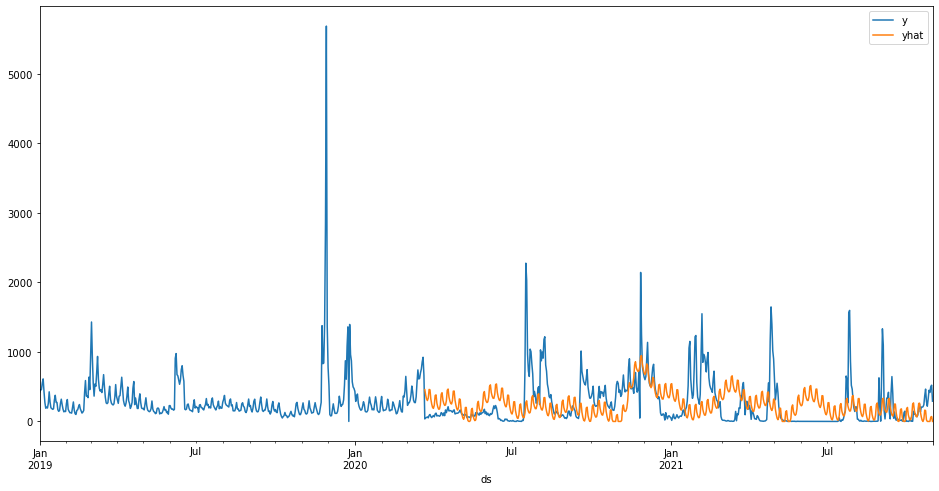

In [ ]:
# Predict on the test data set to see the baseline model performance
future = df_test.drop(columns=['y'])
forecast = m.predict(future)
forecast['yhat'][forecast['yhat'] < 0] = 0 # Set negative forecasts to zero
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()
plt.rcParams["figure.figsize"]=(16,8)
pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot()

In [ ]:
# Calculate RMSE
print('The RMSE was: {}'.format(rmse(forecast['yhat'], df_test['y'])))

The RMSE was: 411.54


## Model With Seasonalities and Feature Engineering

#### Feature Engineering: Removing Sales Outliers

We will identify outliers by flagging any day with sales values that are greater than 2 standard deviations above the average, and then filling them with imputed values using interpolation.

In [ ]:
# Calculate the mean and standard deviation
mu = df['y'].mean()
sigma = df['y'].std()
threshold = mu + (sigma*2)
threshold

966.6015558818435

In [ ]:
# Detect outliers
df['outlier'] = 0
df['outlier'][df['y'] > threshold] = 1
df['outlier'].value_counts()

0    997
1     38
Name: outlier, dtype: int64

<AxesSubplot:xlabel='ds'>

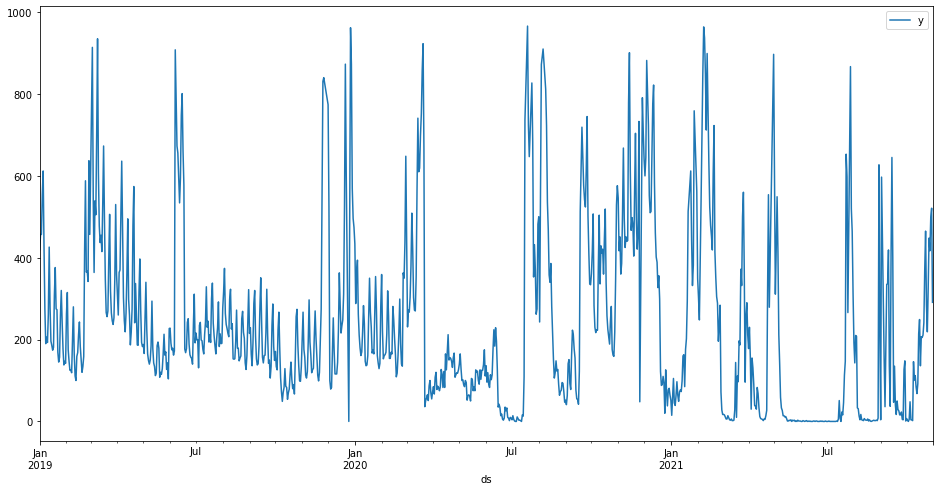

In [ ]:
# Delete outlier values
df['y'][df['outlier'] == 1] = None
# Impute the values using interpolation
df['y'] = df['y'].interpolate()
# Plot the new data
df.plot(x='ds', y='y')

In [ ]:
# We need to recreate the training and test data now that the outcome data have changed
df_train = df[(df['ds'] <= '2020-03-21')]
df_test = df[(df['ds'] > '2020-03-21')]

In [ ]:
#initializing the prophet model and tuning the hyper parameters.
m = Prophet(daily_seasonality = True
            ,weekly_seasonality = True
            ,yearly_seasonality = True)

In [ ]:
#fitting the prophet model on the training dataset
m.fit(df_train)

Initial log joint probability = -28.0689


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       698.898   0.000521107       89.2802      0.1063           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       698.981   0.000254008       96.7076   2.386e-06       0.001      189  LS failed, Hessian reset 
     199       699.027   0.000141202       93.3788           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       699.033   2.76096e-08       96.2478      0.2583           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds'>

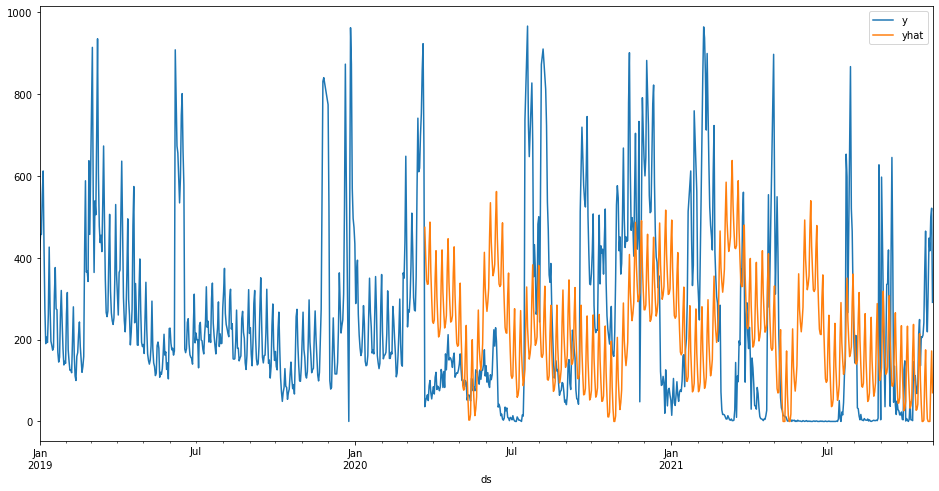

In [ ]:
# Predict on the test data set to see the baseline model performance
future = df_test.drop(columns=['y'])
forecast = m.predict(future)
forecast['yhat'][forecast['yhat'] < 0] = 0 # Set negative forecasts to zero
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()
plt.rcParams["figure.figsize"]=(16,8)
pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot()

In [ ]:
# Calculate RMSE
print('The RMSE was: {}'.format(rmse(forecast['yhat'], df_test['y'])))

The RMSE was: 308.15


## Model With Seasonalities, Feature Engineering, and Hyperparameter Tuning

#### Hyperparameter Tuning: Grid Search

Code found here: https://medium.com/analytics-vidhya/time-series-analysis-using-prophet-in-python-part-2-hyperparameter-tuning-and-cross-validation-88e7d831a067

In [ ]:
import itertools
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict):
    m = Prophet(**param_dict)
    m.add_country_holidays(country_name='US')
    m.fit(history_df)
    df_cv = cross_validation(m, initial='400 days', period='15 days', horizon = '15 days')
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

if run_mode == 'dev':
    param_grid = {  
                    'changepoint_prior_scale': [0.001],
                    'changepoint_range': [0.8],
                    'seasonality_prior_scale':[1],
                    'holidays_prior_scale':[1],
                    'seasonality_mode': ['multiplicative'],
                    'growth': ['linear'],
                    'daily_seasonality': [1],
                    'weekly_seasonality': [5],
                    'yearly_seasonality': [5],
                  }
elif run_mode == 'prod':
    param_grid = {  
                    'changepoint_prior_scale': [0.001, 0.005, 0.01],
                    'changepoint_range': [0.8, 1.0],
                    'seasonality_prior_scale':[0.1, 1.0, 2.0],
                    'holidays_prior_scale':[1.0],
                    'seasonality_mode': ['multiplicative', 'additive'],
                    'growth': ['linear'],
                    'daily_seasonality': [1],
                    'weekly_seasonality': [1, 3, 5],
                    'yearly_seasonality': [5, 7, 10],
                  }
else:
    raise ValueError('Unknown run_mode value: {}'.format(run_mode))

metrics = ['horizon', 'rmse', 'params'] 

results = []


params_df = create_param_combinations(**param_grid)

# Set the parameters for estimating runtimes. Note that these are derived from 
# manual estimated based on observations of previous trainings. These values
# will change if the search space or the cross validation parameters change.
n_combos = params_df.shape[0]
n_iterations = n_combos * 3
n_sec_per_iter = 3.4

print('The estimated training time is {} hours'.format(round((n_iterations * n_sec_per_iter) / 3600, 2)))

The estimated training time is 0.0 hours


#### Execute The Grid Search

In [ ]:
t0 = time.time()
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df_train,  metrics, param_dict)
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
t1 = time.time()

Initial log joint probability = -28.0689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.0689             0       464.234       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-02-05 00:00:00 and 2020-03-06 00:00:00



Initial log joint probability = -318.158
Iteration  1. Log joint probability =    427.218. Improved by 745.376.
Iteration  2. Log joint probability =    495.714. Improved by 68.4956.
Iteration  3. Log joint probability =    638.166. Improved by 142.452.
Iteration  4. Log joint probability =    658.353. Improved by 20.1868.
Iteration  5. Log joint probability =    666.311. Improved by 7.95814.
Iteration  6. Log joint probability =    671.185. Improved by 4.87354.
Iteration  7. Log joint probability =    671.469. Improved by 0.284224.
Iteration  8. Log joint probability =    673.722. Improved by 2.25328.
Iteration  9. Log joint probability =    673.791. Improved by 0.06828.
Iteration 10. Log joint probability =      673.8. Improved by 0.00920048.
Iteration 11. Log joint probability =    673.902. Improved by 0.102502.
Iteration 12. Log joint probability =    673.914. Improved by 0.0119094.
Iteration 13. Log joint probability =    673.925. Improved by 0.0109142.
Iteration 14. Log joint pr

  0%|          | 0/3 [00:00<?, ?it/s]

Initial log joint probability = -9.3455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58        479.82    2.1142e-09       4568.63      0.0929      0.0929       74   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.36825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.126   2.33053e-06       5029.57           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       505.126   5.14964e-07       5060.18   1.024e-10       0.001      175  LS failed, Hessian reset 
     112       505.128   8.90153e-09       4695.77      0.7367      0.7367      189   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -12.9146
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.9146             0       425.905       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -289.219
Iteration  1. Log joint probability =    356.246. Improved by 645.465.
Iteration  2. Log joint probability =    516.486. Improved by 160.24.
Iteration  3. Log joint probability =     595.08. Improved by 78.5946.
Iteration  4. Log joint probability =    605.715. Improved by 10.6352.
Iteration  5. Log joint probability =    612.885. Improved by 7.16967.
Iteration  6. Log joint probability =    638.849. Improved by 25.9637.
Iteration  7. Log joint probability =     663.32. Improved by 24.4709.
Iteration  8. Log joint probability =    663.719. Improved by 0.399356.
Iteration  9. Log joint probability =    663.968.

Iteration 134. Log joint probability =    664.952. Improved by 1.64766e-07.
Iteration 135. Log joint probability =    664.952. Improved by 4.15762e-07.
Iteration 136. Log joint probability =    664.952. Improved by 1.30101e-07.
Iteration 137. Log joint probability =    664.952. Improved by 4.5042e-07.
Iteration 138. Log joint probability =    664.952. Improved by 9.54548e-08.
Iteration 139. Log joint probability =    664.952. Improved by 4.85072e-07.
Iteration 140. Log joint probability =    664.952. Improved by 6.08011e-08.
Iteration 141. Log joint probability =    664.952. Improved by 5.19728e-07.
Iteration 142. Log joint probability =    664.952. Improved by 2.61421e-08.
Iteration 143. Log joint probability =    664.952. Improved by 5.50131e-07.
Iteration 144. Log joint probability =    664.952. Improved by 2.77683e-06.
Iteration 145. Log joint probability =    664.952. Improved by 8.65658e-07.
Iteration 146. Log joint probability =    664.952. Improved by 2.40124e-07.
Iteration 147

#### Examine Optimal Hyperparameters

In [ ]:
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print('Training took {} hours to complete.'.format(round((t1 - t0) / 3600, 2)))
print(f'\n The best param combination is {best_param.values[0][0]}')

Training took 0.0 hours to complete.

 The best param combination is {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'seasonality_prior_scale': 1, 'holidays_prior_scale': 1, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'daily_seasonality': 1, 'weekly_seasonality': 5, 'yearly_seasonality': 5}


#### Train Model Using Optimal Hyperparameters

In [ ]:
m = Prophet(changepoint_prior_scale = 0.001
            ,changepoint_range = 0.8
            ,seasonality_prior_scale = 1
            ,holidays_prior_scale= 1
            ,seasonality_mode = 'multiplicative'
            ,growth = 'linear'
            ,daily_seasonality = 1
            ,weekly_seasonality = 5
            ,yearly_seasonality = 5
            ,holidays=holidays)

In [ ]:
#fitting the prophet model on the training dataset
m.fit(df_train)

Initial log joint probability = -28.0689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.0689             0       464.234       1e-12       0.001       19   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -315.401


Iteration  1. Log joint probability =    426.474. Improved by 741.875.
Iteration  2. Log joint probability =    492.221. Improved by 65.747.
Iteration  3. Log joint probability =    634.215. Improved by 141.994.
Iteration  4. Log joint probability =    656.561. Improved by 22.3458.
Iteration  5. Log joint probability =     664.36. Improved by 7.79865.
Iteration  6. Log joint probability =     680.61. Improved by 16.2499.
Iteration  7. Log joint probability =    680.852. Improved by 0.24187.
Iteration  8. Log joint probability =    683.166. Improved by 2.31416.
Iteration  9. Log joint probability =    683.229. Improved by 0.0631305.
Iteration 10. Log joint probability =    683.242. Improved by 0.0125093.
Iteration 11. Log joint probability =    683.339. Improved by 0.0975155.
Iteration 12. Log joint probability =    683.367. Improved by 0.0280102.
Iteration 13. Log joint probability =    683.383. Improved by 0.0159278.
Iteration 14. Log joint probability =    683.391. Improved by 0.0075

<AxesSubplot:xlabel='ds'>

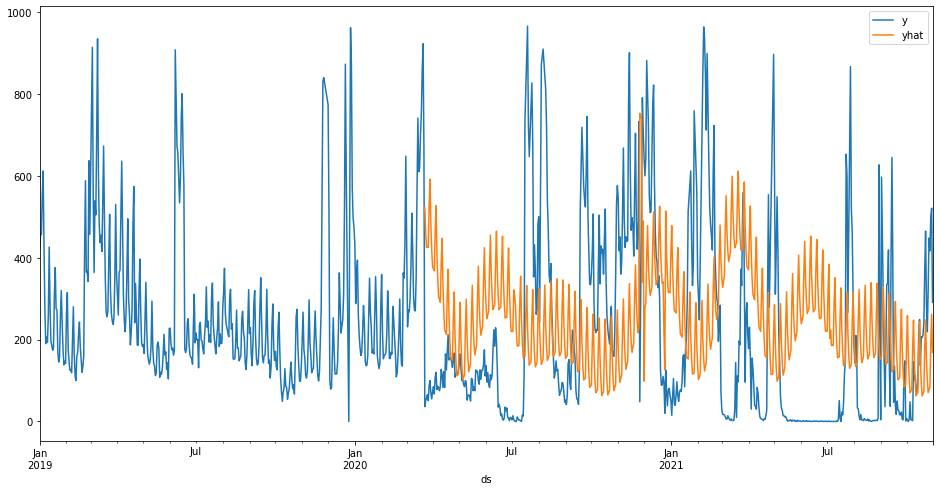

In [ ]:
# Predict on the test data set to see the baseline model performance
future = df_test.drop(columns=['y'])
forecast = m.predict(future)
forecast['yhat'][forecast['yhat'] < 0] = 0 # Set negative forecasts to zero
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()
plt.rcParams["figure.figsize"]=(16,8)
pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot()

In [ ]:
# Calculate RMSE
print('The RMSE was: {}'.format(rmse(forecast['yhat'], df_test['y'])))

The RMSE was: 291.88


## Model With Seasonalities, Feature Engineering, Tuned Hyperparameters, and Additional Covariates

#### Additional Covariates

We will use the model defined in the previous section (with tuned hyperparameters), then add some additional regressors to the model from data that we have provided.

In [ ]:
#Adding additional regressors to the prophet model.
m = Prophet(changepoint_prior_scale = 0.001
            ,changepoint_range = 0.8
            ,seasonality_prior_scale = 1
            ,holidays_prior_scale= 1
            ,seasonality_mode = 'multiplicative'
            ,growth = 'linear'
            ,daily_seasonality = 1
            ,weekly_seasonality = 5
            ,yearly_seasonality = 5
            ,holidays=holidays)
m.add_country_holidays(country_name='US')
m.add_regressor('Inv_flag_wh', prior_scale = 25, mode = "additive")
m.add_regressor('ASP')
m.add_regressor('No_of_days_first_Ecomm_sale_Date', prior_scale = 25)

In [ ]:
#fitting the prophet model on the training dataset
m.fit(df_train)

Initial log joint probability = -28.0689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -28.0689             0       478.841       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -324.596


Iteration  1. Log joint probability =     322.58. Improved by 647.176.
Iteration  2. Log joint probability =     404.62. Improved by 82.0398.
Iteration  3. Log joint probability =    602.738. Improved by 198.119.
Iteration  4. Log joint probability =    640.762. Improved by 38.0233.
Iteration  5. Log joint probability =    743.116. Improved by 102.354.
Iteration  6. Log joint probability =    771.625. Improved by 28.5093.
Iteration  7. Log joint probability =    774.343. Improved by 2.71739.
Iteration  8. Log joint probability =    778.973. Improved by 4.62977.
Iteration  9. Log joint probability =    779.945. Improved by 0.972488.
Iteration 10. Log joint probability =    780.872. Improved by 0.92681.
Iteration 11. Log joint probability =    781.073. Improved by 0.201178.
Iteration 12. Log joint probability =    781.511. Improved by 0.438457.
Iteration 13. Log joint probability =    781.768. Improved by 0.256262.
Iteration 14. Log joint probability =    781.943. Improved by 0.175563.
I

<AxesSubplot:xlabel='ds'>

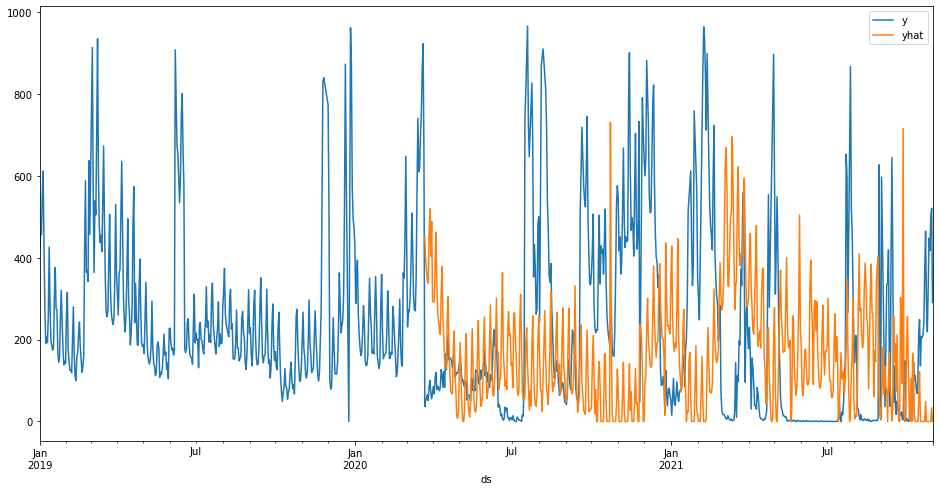

In [ ]:
# Predict on the test data set to see the baseline model performance
future = df_test.drop(columns=['y'])
forecast = m.predict(future)
forecast['yhat'][forecast['yhat'] < 0] = 0 # Set negative forecasts to zero
forecast[['ds','yhat','yhat_lower', 'yhat_upper']].tail()
plt.rcParams["figure.figsize"]=(16,8)
pd.concat([df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis = 1).plot()

In [ ]:
# Calculate RMSE
print('The RMSE was: {}'.format(rmse(forecast['yhat'], df_test['y'])))

The RMSE was: 321.34


In [ ]:
fig = m.plot_components(forecast)
